In [27]:
from semantic_router import Route
from semantic_router.encoders import OpenAIEncoder, HuggingFaceEncoder
from semantic_router import RouteLayer
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [28]:
# Load the dataframes json files
df_synthetic = pd.read_json("synthetic_intetions.json")

X_syn = df_synthetic[['Id','Message']]
y_syn = df_synthetic['Intention'].to_list()

In [30]:
# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_syn, y_syn, test_size=0.25, random_state=42, stratify=y_syn, shuffle=True
)

In [32]:
# Replace "None" with None
y_train = [None if y == 'None' else y for y in y_train]
y_test = [None if y == 'None' else y for y in y_test]

In [33]:
update_claim_status_messages = []
get_claim_info_messages = []
get_policy_info_messages = []

for message, label in zip(X_train["Message"], y_train):
    if label == 'update_claim_status':
        update_claim_status_messages.append(message)
    elif label == 'get_claim_info':
        get_claim_info_messages.append(message)
    elif label == 'get_policy_info':
        get_policy_info_messages.append(message)

update_claim_status = Route(
    name="update_claim_status",
    description="The user wants to update the status of a claim.",
    utterances=update_claim_status_messages,
)

get_claim_info = Route(
    name="get_claim_info",
    description="The user intends to get information about the claims.",
    utterances=get_claim_info_messages,
)

get_policy_info = Route(
    name="get_policy_info",
    description="The user is interested in obtaining information about a policy.",
    utterances=get_policy_info_messages,
)

In [34]:
routes = [update_claim_status, get_claim_info,  get_policy_info]
encoder = HuggingFaceEncoder()

In [35]:
hf_rl = RouteLayer(encoder=encoder, routes=routes,  aggregation='sum', top_k=6) #aggregation = "mean", "max" or "sum". #top_k = 5

In [36]:
# Call the fit method
hf_rl.fit(X=X_train["Message"].to_list(), y=y_train, max_iter=25)

Training: 100%|██████████| 25/25 [00:00<00:00, 65.17it/s, acc=1]


In [37]:
accuracy = hf_rl.evaluate(X=X_train["Message"].to_list(), y=y_train)
print(f"Train Accuracy: {accuracy*100:.2f}%")
accuracy = hf_rl.evaluate(X=X_test["Message"].to_list(), y=y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Train Accuracy: 100.00%


Generating embeddings: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

Test Accuracy: 97.14%


In [43]:
train_pred = []
test_pred = []
for i in range(len(X_train)):
    train_pred.append(hf_rl(X_train.iloc[i].Message).name)
for i in range(len(X_test)):
    test_pred.append(hf_rl(X_test.iloc[i].Message).name)

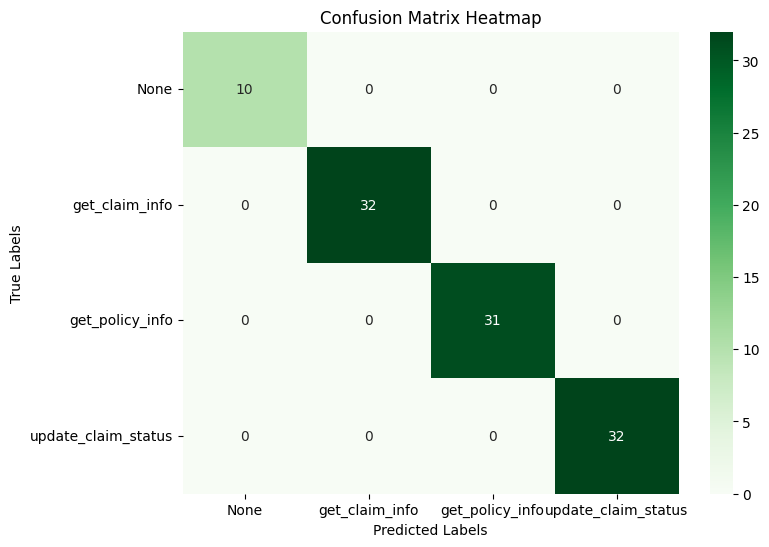

In [45]:
labels = sorted(set([y if y is not None else 'None' for y in y_train]))

# Compute confusion matrix
conf_matrix = confusion_matrix([y if y is not None else 'None' for y in y_train], [y if y is not None else 'None' for y in train_pred], labels=labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

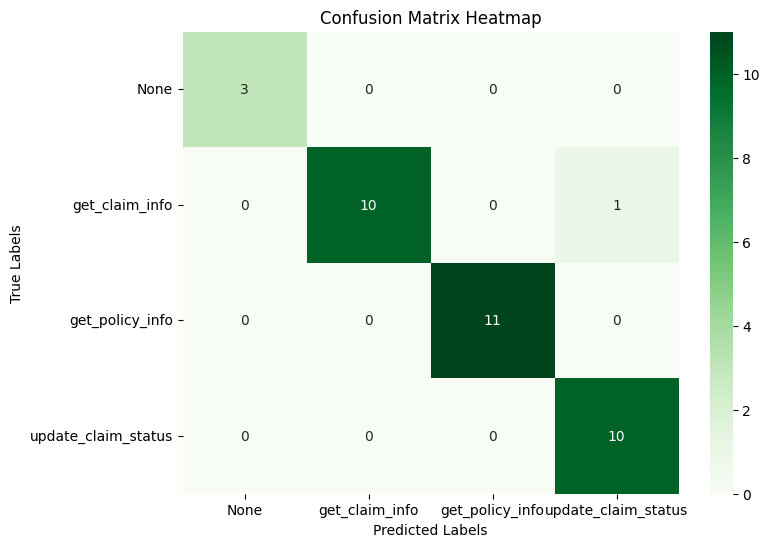

In [44]:
labels = sorted(set([y if y is not None else 'None' for y in y_test]))

# Compute confusion matrix
conf_matrix = confusion_matrix([y if y is not None else 'None' for y in y_test], [y if y is not None else 'None' for y in test_pred], labels=labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [46]:
hf_rl.to_json("layer.json")

2025-02-09 18:28:19 INFO semantic_router.utils.logger Saving route config to layer.json
